In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf

/Users/Ryan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from keras.utils import to_categorical

Using TensorFlow backend.


Will implement [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM] and write script to print accuracy of models on test and train data

# Preprocess the Data

In [4]:
data = pd.read_csv("./data/handwritten_data_785.csv", encoding = "utf8")

In [5]:
np.random.seed(0)
data = data.values
np.random.shuffle(data)
X, y = data[:,1:], data[:,0]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print("Train: {} {}".format(X_train.shape, y_train.shape))
print("Valid: {} {}".format(X_valid.shape, y_valid.shape))
print("Test: {} {}".format(X_test.shape, y_test.shape))

Train: (238103, 784) (238103,)
Valid: (59526, 784) (59526,)
Test: (74408, 784) (74408,)


In [17]:
mean_image = np.mean(X_train, axis=0).astype(np.int64)
X_train = (X_train - mean_image)/255
X_test = (X_test - mean_image)/255

In [18]:
train_Y_one_hot = to_categorical(y_train)
valid_Y_one_hot = to_categorical(y_valid)
test_Y_one_hot = to_categorical(y_test)

# Data Dimensions

In [26]:
print(X_train.shape)
print(X_test.shape)

#images are 28x28
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

num_channels = 1
num_classes = 26

X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_size, img_size, 1)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 1)

(238103, 28, 28, 1)
(74408, 28, 28, 1)


# Test: One layer of each ([conv-relu-pool] -> [affine]-> [softmax or SVM])

Remember, deeper networks is always better, at the cost of more data and increased complexity of learning.
Minibatch size is usually set of few hundreds. 
You should initially use fewer filters and gradually increase and monitor the error rate to see how it is varying.
Very small filter sizes will capture very fine details of the image. On the other hand having a bigger filter size 
will leave out minute details in the image.
https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN

# Keras Model

In [20]:
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras import initializers
from keras.wrappers.scikit_learn import KerasClassifier

optimizer = Adam(lr=1e-3)

In [23]:
'''
    Function to create model, required for KerasClassifier
    
    We pass this function name to the KerasClassifier class by the build_fn argument. 
    We also pass in additional arguments of epochs and batch_size. 
    These are automatically bundled up and passed on to the fit() function which is called 
    internally by the KerasClassifier class.
    
    https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
'''
def create_model():
    model = Sequential()
    '''
    initializer: he_normal
    A more recent paper on this topic, Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification by He et al., 
    derives an initialization specifically for ReLU neurons, reaching the conclusion that the variance of neurons 
    in the network should be 2.0/n. This gives the initialization w = np.random.randn(n) * sqrt(2.0/n), 
    and is the current recommendation for use in practice in the specific case of neural networks with ReLU neurons.
    '''
    #convolutional layer
    model.add(Conv2D(kernel_size=7, strides=1, filters=16, padding='same',
                     activation='linear', name='layer_conv1', input_shape=img_shape_full))
    #reLU activation
    model.add(LeakyReLU(alpha=0.1))
    #Pooling Layer
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    model.add(Flatten())
    #Fully-Connected Layer with 128 outputs Adding this in improved scores
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    #Fully-Connected Layer with Softmax
    model.add(Dense(num_classes, activation='softmax'))

    '''
    For multiclass classification problems like MNIST, cross entropy is typically used as the loss metric
    '''
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
#model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=150, verbose=1)
model = create_model()

# Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [33]:
'''
    Must use non-one-hot data:
        
    keras.utils.to_categorical produces a one-hot encoded class vector, i
    .e. the multilabel-indicator mentioned in the error message. 
    StratifiedKFold is not designed to work with such input;
    from:
    https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
'''
kfold = StratifiedKFold(n_splits=5, shuffle=False)
results = cross_val_score(model, X_train, y_train, cv=kfold)
model_accuracy = results.mean()

Epoch 1/3
238093/238093 [==============================] - 260s 1ms/step - loss: 0.1535 - acc: 0.9582
Epoch 2/3
238093/238093 [==============================] - 341s 1ms/step - loss: 0.0721 - acc: 0.9807
Epoch 3/3
59536/59536 [==============================] - 23s 394us/step
Epoch 1/3
238098/238098 [==============================] - 242s 1ms/step - loss: 0.1502 - acc: 0.9589
Epoch 2/3
238098/238098 [==============================] - 206s 865us/step - loss: 0.0706 - acc: 0.9812
Epoch 3/3
59531/59531 [==============================] - 18s 301us/step
Epoch 1/3
238105/238105 [==============================] - 180s 758us/step - loss: 0.1482 - acc: 0.9596
Epoch 2/3
238105/238105 [==============================] - 206s 866us/step - loss: 0.0704 - acc: 0.9810
Epoch 3/3
59524/59524 [==============================] - 22s 370us/step
Epoch 1/3
238108/238108 [==============================] - 217s 913us/step - loss: 0.1521 - acc: 0.9582
Epoch 2/3
238108/238108 [==============================] - 233

In [34]:
print("Model Cross-Validation Accuracy = ", model_accuracy)

Model Cross-Validation Accuracy =  0.9817255074409299


<strong>without he_normal weights initialization and 0.01 biases initialization:</strong>

Train on 297629 samples, validate on 74408 samples

Epoch 1/1
loss: 0.1502 - acc: 0.9591 

val_loss: 0.0927 - val_acc: 0.9762

<strong>using he_normal weight initialization and 0.01 biases initialization actually decreased accuracy by 0.0014</strong>

Train on 297629 samples, validate on 74408 samples

Epoch 1/1

loss: 0.1835 - acc: 0.9494 - 

val_loss: 0.0963 - val_acc: 0.9748

In [27]:
model_train = model.fit(x=X_train,
          y=train_Y_one_hot,
          epochs=20, batch_size=128,verbose=1, validation_data=(X_valid, valid_Y_one_hot))

Train on 238103 samples, validate on 59526 samples
Epoch 1/20
238103/238103 [==============================] - 195s 821us/step - loss: 0.2138 - acc: 0.9413 - val_loss: 1.8904 - val_acc: 0.8814
Epoch 2/20
238103/238103 [==============================] - 148s 620us/step - loss: 0.0894 - acc: 0.9760 - val_loss: 1.5729 - val_acc: 0.9013
Epoch 3/20
238103/238103 [==============================] - 142s 596us/step - loss: 0.0695 - acc: 0.9810 - val_loss: 1.5663 - val_acc: 0.9019
Epoch 4/20
238103/238103 [==============================] - 148s 623us/step - loss: 0.0568 - acc: 0.9844 - val_loss: 0.9309 - val_acc: 0.9416
Epoch 5/20
238103/238103 [==============================] - 139s 586us/step - loss: 0.0474 - acc: 0.9866 - val_loss: 1.0503 - val_acc: 0.9342
Epoch 6/20
238103/238103 [==============================] - 140s 587us/step - loss: 0.0398 - acc: 0.9887 - val_loss: 1.5977 - val_acc: 0.9003
Epoch 7/20
238103/238103 [==============================] - 136s 570us/step - loss: 0.0337 - acc:

In [29]:
test_eval = model.evaluate(X_test, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.06679204746351072
Test accuracy: 0.9885093000752607


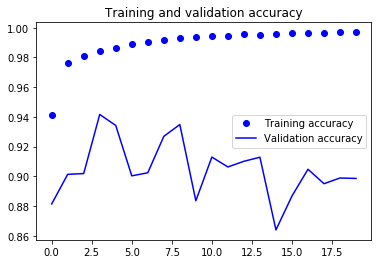

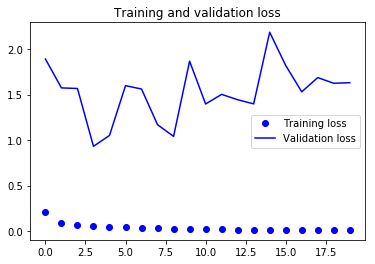

In [30]:
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()